In [1]:
from gumbel_sigmoid import GumbelSigmoid,GumbelSigmoidLayer
import theano.tensor as T
import numpy as np

### Simple demo
* Sample from gumbel-softmax
* Average over samples

In [2]:
temperature = 0.1
logits = np.linspace(-5,5,10).reshape([1,-1])
gumbel_sigm = GumbelSigmoid(t=temperature)(logits)
sigm = T.nnet.sigmoid(logits)

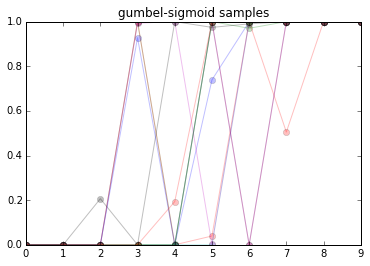

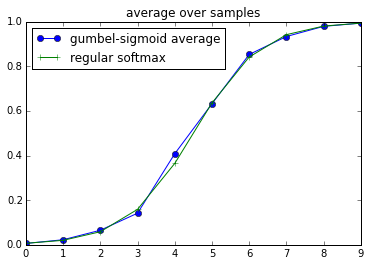

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('gumbel-sigmoid samples')
for i in range(10):
    plt.plot(range(10),gumbel_sigm.eval()[0],marker='o',alpha=0.25)
plt.ylim(0,1)
plt.show()

plt.title('average over samples')
plt.plot(range(10),np.mean([gumbel_sigm.eval()[0] for _ in range(500)],axis=0),
         marker='o',label='gumbel-sigmoid average')

plt.plot(sigm.eval()[0],marker='+',label='regular softmax')
plt.legend(loc='best')

# Autoencoder with gumbel-softmax

* We do not use any bayesian regularization, simply optimizer by backprop
* Hidden layer contains 32 units

In [4]:
from sklearn.datasets import load_digits
X = load_digits().data

In [5]:
import lasagne
from lasagne.layers import *
import theano

#graph inputs and shareds
input_var = T.matrix()
temp = theano.shared(np.float32(1),'temperature',allow_downcast=True)

#architecture: encoder
nn = l_in = InputLayer((None,64),input_var)
nn = DenseLayer(nn,64,nonlinearity=T.tanh)
nn = DenseLayer(nn,32,nonlinearity=T.tanh)

#bottleneck
nn = DenseLayer(nn,32,nonlinearity=None)#or nonlinearity=GumbelSigmoid(t=temp)
bottleneck = nn = GumbelSigmoidLayer(nn,t=temp)

#decoder
nn = DenseLayer(nn,32,nonlinearity=T.tanh)
nn = DenseLayer(nn,64,nonlinearity=T.tanh)
nn = DenseLayer(nn,64,nonlinearity=None)

#loss and updates
loss = T.mean((get_output(nn)-input_var)**2)
updates = lasagne.updates.adam(loss,get_all_params(nn))

#compile
train_step = theano.function([input_var],loss,updates=updates)
evaluate = theano.function([input_var],loss)

## Training loop
* We gradually reduce temperature from 1 to 0.01 over time

In [6]:
for i,t in enumerate(np.logspace(0,-2,10000)):
    sample = X[np.random.choice(len(X),32)]
    temp.set_value(t)
    mse = train_step(sample)
    if i %100 ==0:
        print '%.3f'%evaluate(X),

59.725 21.948 18.904 18.790 18.781 18.784 18.793 18.790 18.783 18.792 18.786 18.787 18.790 18.784 18.791 18.788 18.667 18.148 17.381 16.659 16.151 15.521 14.731 13.898 13.334 12.917 12.266 11.772 11.461 11.161 10.893 10.671 10.522 10.318 10.111 9.950 9.789 9.664 9.483 9.422 9.331 9.245 9.124 9.033 8.934 8.815 8.792 8.708 8.667 8.538 8.522 8.443 8.378 8.304 8.257 8.194 8.134 8.064 8.026 7.982 7.854 7.859 7.788 7.801 7.722 7.741 7.664 7.673 7.649 7.556 7.562 7.516 7.518 7.420 7.406 7.353 7.509 7.396 7.412 7.439 7.341 7.372 7.283 7.296 7.242 7.205 7.210 7.364 7.306 7.156 7.266 7.287 7.251 7.124 7.174 7.136 7.171 7.281 7.427 7.363


In [7]:
#functions for visualization
get_sample = theano.function([input_var],get_output(nn))
get_sample_hard = theano.function([input_var],get_output(nn,hard_max=True))
get_code = theano.function([input_var],get_output(bottleneck,hard_max=False))


WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


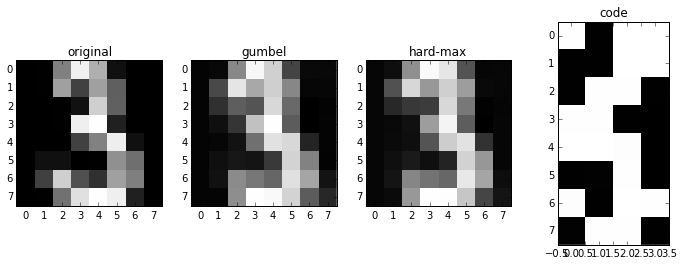

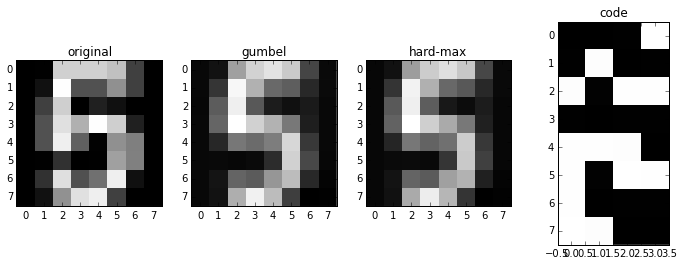

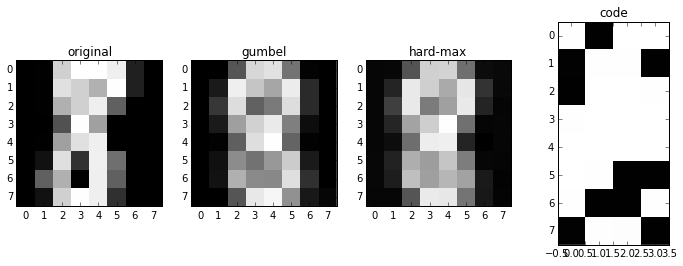

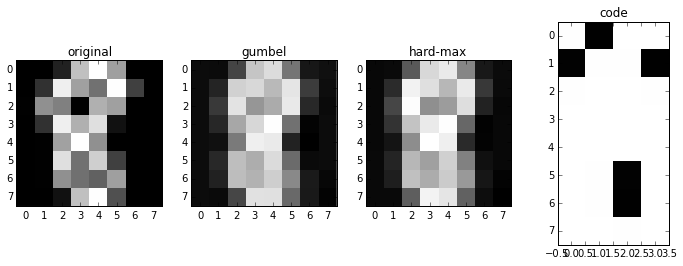

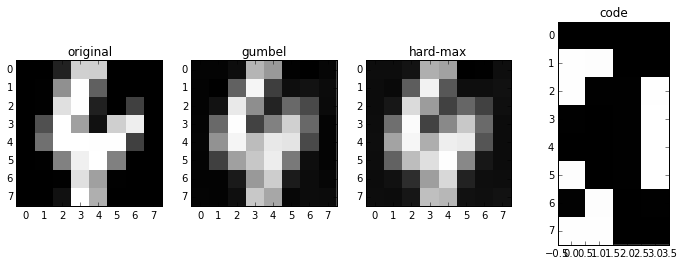

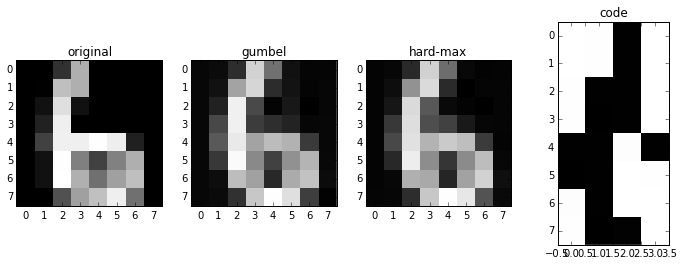

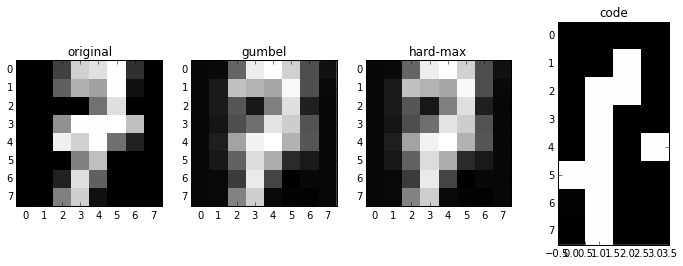

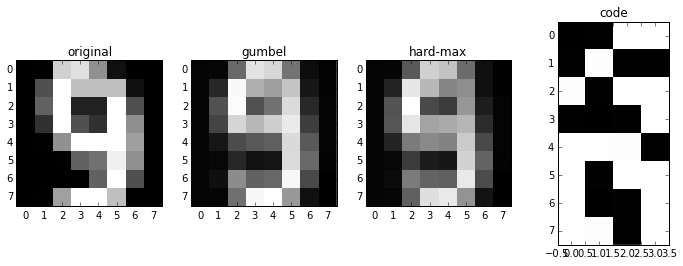

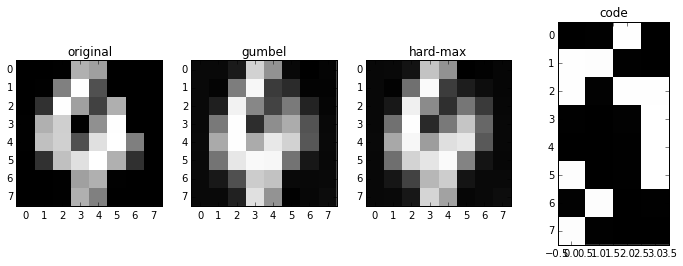

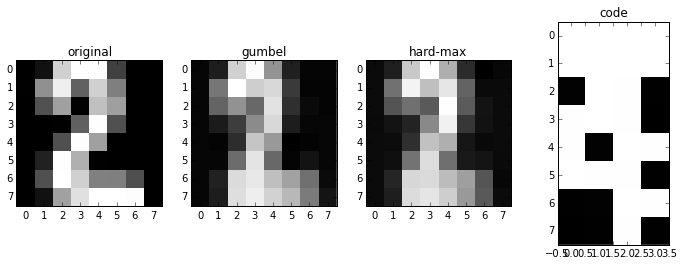

In [8]:
for i in range(10):
    X_sample = X[np.random.randint(len(X)),None,:]
    plt.figure(figsize=[12,4])
    plt.subplot(1,4,1)
    plt.title("original")
    plt.imshow(X_sample.reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,2)
    plt.title("gumbel")
    plt.imshow(get_sample(X_sample).reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,3)
    plt.title("hard-max")
    plt.imshow(get_sample_hard(X_sample).reshape([8,8]),interpolation='none',cmap='gray')
    plt.subplot(1,4,4)
    plt.title("code")
    plt.imshow(get_code(X_sample).reshape(8,4),interpolation='none',cmap='gray')
    plt.show()